In [104]:
import spei as sp #spei package
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as scs
from joblib import Parallel, delayed
import multiprocessing
import mhm_dataprocessing as md
import geopandas as gpd
from joblib import Parallel, delayed
from tqdm import tqdm  # pip install tqdm

In [93]:
src = r'W:\VUB\_main_research\mHM\mhm_outputs\mHM_EOBS\met_inputs'
pet = xr.open_dataset(f'{src}/pet.nc')
pre = xr.open_dataset(f'{src}/pre.nc')

#BE shapefile
be_shp = gpd.read_file(r"W:\VUB\_main_research\mHM\mhm_belgium\be_shp\be_joined_epsg_32631.shp")

#### clip the Datasets to BE boundary
pet_BE = md.clip_to_region(be_shp, pet)
pre_BE = md.clip_to_region(be_shp, pre)

#mask areas with constant values using dta variance
pet_BE = pet_BE.where(pet_BE.pet.var(dim='time') > 0.001, drop=False)
pre_BE = pre_BE.where(pre_BE.pre.var(dim='time') > 0.001, drop=False)

#slide data to start from 1970
pet_BE = pet_BE.sel(time=slice('1970-01-01', None))
pre_BE = pre_BE.sel(time=slice('1970-01-01', None))

### Precipitation accumulation for SPI3, SPI6, SPI12

In [99]:
#apply a 90-day moving average to precipitation
f = 90  # days
precip = pre_BE.pre.rolling(time=f).sum()

#example application for spi
# pre_tx = precip.sel(lat=49, lon=6, method='nearest').to_series()
# spi_3 = sp.spi(pre_tx, dist=scs.gamma, fit_freq="ME")

In [ ]:
# Preallocate arrays for storing the CDF and bins
nlat, nlon = len(pre.lat), len(pre.lon)
spi_array = np.full((nlat, nlon, len(precip)), np.nan)

meteo_dataset = precip

for j in range(nlat):
        for i in range(nlon):
            # Extract soil moisture time series for the current grid cell
            tx_var = meteo_dataset.isel(lat=j, lon=i).to_series()
            
            # Skip if all NaN
            if np.isnan(tx_var).all():
                continue
            
            # Check variance
            if np.std(tx_var) < 1e-6:
                # Skip if there's essentially no variation
                continue

            #compute the spi3
            #print progress of grid numbers
            print(f'Processing grid cell {j+1}/{nlat}, {i+1}/{nlon}', end='\r')
            # Calculate the SPI for the current grid cell
            spi_3 = sp.spi(tx_var, dist=scs.gamma, fit_freq="ME") 

            # Store in the preallocated arrays
            spi_array[j, i, :] = spi_3

#### GRid Cell SPI3

In [ ]:
nlat, nlon = len(precip.lat), len(precip.lon)
ntime = len(precip.time)
spi_array = np.full((nlat, nlon, ntime), np.nan)

# Function for one grid cell
def compute_spi_cell(j, i):
    tx_var = precip.isel(lat=j, lon=i).to_series()
    
    if np.isnan(tx_var).all() or np.std(tx_var) < 1e-6:
        return (j, i, np.full(ntime, np.nan))
    spi_3 = sp.spi(tx_var, dist=scs.gamma, fit_freq="ME")
    return (j, i, spi_3)

# Progress bar wrapper around the iterator
results = Parallel(n_jobs=-1)(
    delayed(compute_spi_cell)(j, i)
    for j in range(nlat)
    for i in tqdm(range(nlon), desc=f'Processing lat row {j+1}/{nlat}')
)

# Fill result array
for j, i, spi_vals in results:
    spi_array[j, i, :] = spi_vals

Processing lat row 11/31: 100%|██████████| 61/61 [00:12<00:00,  5.06it/s]


In [65]:
#convert to xarray DataArray
spi3_da = xr.DataArray(
    spi_array,
    coords={
        'lat': pre.lat,
        'lon': pre.lon,
        'time': pre.time
    },
    dims=['lat', 'lon', 'time'],
    name='spi_3'
)

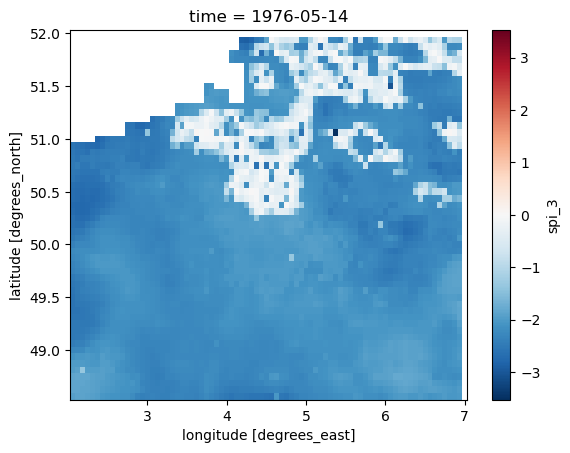

In [66]:
spi3_da.isel(time=9630).plot()

<Axes: xlabel='time'>

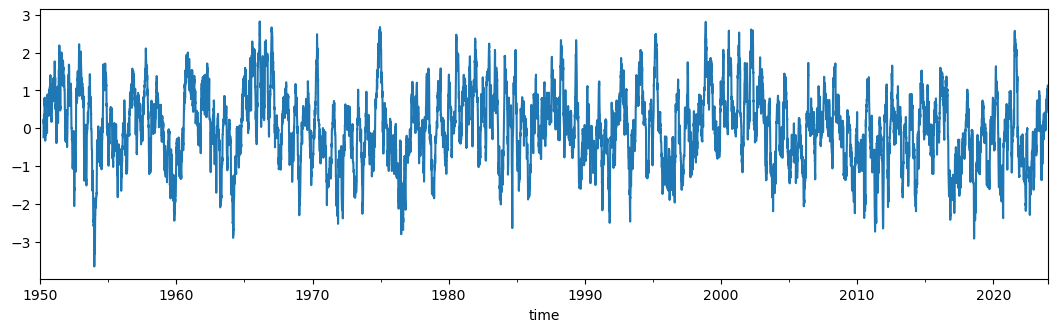

In [67]:
spi3_da.sel(lat=50.5, lon=5, method='nearest').to_series().plot(figsize=(13, 3.5))